# Homework 3 Part 2

## Course Name: Deep Learning
#### Lecturers: Dr. Beigy

---

#### Notebooks Supervised By: Zeinab Sadat Taghavi
#### Notebooks Prepared By: Zahra Khoramnejad, Mehran Sarmadi, Zahra Rahimi

**Contact**: Ask your questions in Quera

---

### Instructions:
- Complete all exercises presented in this notebook.
- Ensure you run each cell after you've entered your solution.
- After completing the exercises, save the notebook and <font color='red'>follow the submission guidelines provided in the PDF.</font>


---


#Text Generation

<p align='justify'>Text generation task involves generating new text based on a given input or a prompt. It is a natural language processing (NLP) task that aims to generate coherent and contextually relevant text.

In text generation, a model is trained on a large corpus of text data and learns the patterns and structures of the language. This model can then be used to generate new text by sampling from the learned distribution of words or characters.

Text generation has various applications, including chatbots, language translation, poetry generation, and content creation. It can be implemented using different techniques such as `recurrent neural networks (RNNs)`, `transformers`, and `Markov chains`.

The goal of text generation is to produce text that is fluent, coherent, and contextually relevant. It requires a deep understanding of the language and the ability to generate text that follows grammatical rules and maintains semantic coherence.</p>

##Charachter-level text generation

One stage of the task of text generation is mapping, which can be at the word or character level. At this stage, a number is assigned to each word or character.

In this exercise, we generate text at the character level. Because generating text at the word level, even though it leads to more meaningful outputs, requires a rich dataset with a high number of word repetitions.

We will implement models based on `recurrent networks` for text generation and compare the performance of different models. In the following, we will check the performance of the best models on different datasets and compare the results

The steps of this exercise are as follows:
1. Train RNN and LSTM
2. FineTuning
3. Experiment on different datasets

---
---

#1. Train RNN and LSTM

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

import numpy as np
import pandas as pd
import random
import re
import string

import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load data

- We use the dataset of `Shakespeare's plays` as the main dataset for this exercise

In [2]:
!wget "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt" -c -P {'data/'}

--2023-12-06 21:03:47--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘data/input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2023-12-06 21:03:47 (22.4 MB/s) - ‘data/input.txt’ saved [1115394/1115394]



- Load data in amout of 30kb for training models

In [3]:
sh_data_file = "./data/input.txt"
sh_data = open(sh_data_file, 'r').read(30000)

##Charachter mapping

- For better performance of the model, we limit the set of allowed characters

In [4]:
chars = list(string.ascii_lowercase + '\n' + ' ' + ':' + '.')
vocab_size = len(chars)

In [5]:
# Mapping of char-index
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

##Preprocessing

In [6]:
def remove_extraneous_characters(data, valid_char_list):
    pattern = f"[^{re.escape(''.join(valid_char_list))}]"
    return re.sub(pattern, '', data)

In [7]:
sh_data = remove_extraneous_characters(sh_data.lower(), chars)
sh_data_size = len(sh_data)

# Extract indexes of data characters
sh_data = list(sh_data)
for i, ch in enumerate(sh_data):
    sh_data[i] = char_to_ix[ch]

sh_data = torch.tensor(sh_data).to(device)
sh_data = torch.unsqueeze(sh_data, dim=1)

##Modeling

- In this part define RNN and LSTM model, according to the mentioned characteristics and function inputs.


###RNN

In [8]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=512, num_layers=3, dropout_enable=False):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_enable = dropout_enable
        self.dropout = nn.Dropout(0.5)
        self.hidden_state = None
        ####################################
        ######### Your code begins #########
        ####################################
        # Define self.rnn with model inputs
        # Define self.decoder for decoding output character from last hidden state
        # You can use torch.nn library

        self.encoder = nn.Embedding(input_size, input_size)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

        ####################################
        ######### Your code ends ###########
        ####################################


    def forward(self, input_seq, hidden_state=None):
        ####################################
        ######### Your code begins #########
        ####################################
        # Implement forward part of model and save last hidden state on self.hidden_state
        # print(f'{input_seq.size()=}')
        x_encoded = self.encoder(input_seq)
        # print(f'{x_encoded.size()=}')
        output, hn = self.rnn(x_encoded, hidden_state)
        # print(f'{output.size()=}')
        self.hidden_state = hn.detach()

        if self.dropout_enable:
            output = self.dropout(output)
        output = self.decoder(output)

        ####################################
        ######### Your code ends ###########
        ####################################

        return output

    def save_model(self, path):
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        self.load_state_dict(torch.load(path))

###LSTM

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=512, num_layers=3, dropout_enable=False):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_enable = dropout_enable
        self.dropout = nn.Dropout(0.5)
        self.hidden_state = None

        ####################################
        ######### Your code begins #########
        ####################################
        # Define self.lstm with model inputs
        # Define self.decoder for decoding output character from last hidden state
        # You can use torch.nn library

        self.encoder = nn.Embedding(input_size, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

        ####################################
        ######### Your code ends ###########
        ####################################

    def forward(self, input_seq, hidden_state=None):
        ####################################
        ######### Your code begins #########
        ####################################
        # Implement forward part of model and save last hidden state on self.hidden_state
        x_encoded = self.encoder(input_seq)
        output, hn = self.lstm(x_encoded, hidden_state)
        self.hidden_state = (hn[0].detach(), hn[1].detach())

        if self.dropout_enable:
            output = self.dropout(output)
        output = self.decoder(output)

        ####################################
        ######### Your code ends ###########
        ####################################

        return output

    def save_model(self, path):
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        self.load_state_dict(torch.load(path))

##Training

In [10]:
def print_sample_output(model, data, data_size, test_output_len = 200):
    # Use this function to print sample that model generates from its current hidden state and random input character
    # test_output_len is total num of characters in output test sequence

    test_output = ""
    data_ptr = 0

    rand_index = np.random.randint(data_size-1)
    input_seq = data[rand_index : rand_index+1]

    model.hidden_state = None

    while True:
        output = model(input_seq, model.hidden_state)

        output = F.softmax(torch.squeeze(output), dim=0)
        dist = Categorical(output)
        index = dist.sample().item()

        test_output += ix_to_char[index]

        input_seq[0][0] = index
        data_ptr += 1

        if data_ptr > test_output_len:
            break

    print("Train Sample +++++++++++++++++++++++++++++++++++++++++++++")
    print(test_output)
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

- For construction of each sample in the dataset, the output sequence is
obtained from the shift of one character from the input sequence. For example, when sequence_length is 10 and our text is `Hello world`. The input sequence would be `Hello worl`, and the target sequence `ello world`.

In [11]:
def train_epoch(model, data, data_size, epoch, optimizer, seq_len=200):
    # seq_length is length of training data sequence
    model.train()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    sample_number = 0

    ####################################
    ######### Your code begins #########
    ####################################
    # Define training process for one epoch of input model
    # At the end of every ten epochs, print current loss and a sample output of the model using print_sample_output function
    # Feed all data sample to model by iterating over input data
    model.hidden_state = None

    for idx in range(seq_len, data_size - seq_len, 2*seq_len):
        X_train = data[idx:idx+seq_len]
        y_train = data[idx+1:idx+1+seq_len]

        # Forward and loss
        optimizer.zero_grad()
        output = model(X_train, model.hidden_state)
        train_loss = criterion(output.squeeze(), y_train.squeeze())
        total_loss += train_loss.item()
        sample_number += 1

        # Backward and optimization
        train_loss.backward()
        optimizer.step()

    if epoch % 10 == 9:
        with torch.no_grad():
            model.eval()
            print(f'Loss [{epoch=}] = {total_loss / sample_number}')
            print_sample_output(model, data, data_size)
            model.hidden_state = None

    ####################################
    ######### Your code ends ###########
    ####################################

    return total_loss / sample_number

In [12]:
def train_rnn(data, data_size, model_save_file):
    # RNN parameters
    hidden_size = 512
    num_layers = 6
    lr = 0.002
    epoch_num = 100
    losses = [np.inf]

    ####################################
    ######### Your code begins #########
    ####################################
    # Define training process in the specified number of epochs for RNN model
    # Use train_epoch function for train the model for one epoch
    # Use Adam as optimizer
    # Save best model in model_save_file address for next usage
    rnn_model = RNN(vocab_size, vocab_size, hidden_size, num_layers, dropout_enable=False)
    print(rnn_model)
    optimizer = torch.optim.Adam(rnn_model.parameters(), lr)

    data = data.to(device)
    # data_oh = F.one_hot(data.squeeze(), vocab_size).to(torch.float32)

    # dataset = torch.utils.data.TensorDataset(*prepare_dataset(data_oh, look_back=200))
    # dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

    for epoch in range(epoch_num):
        print(f'{epoch=}')
        loss = train_epoch(rnn_model, data, data_size, epoch, optimizer, seq_len=200)
        if loss < losses[-1]:
            rnn_model.save_model(model_save_file)
            print(f'current model with {loss=} saved at {model_save_file}')

        losses.append(loss)

    ####################################
    ######### Your code ends ###########
    ####################################

    return losses

In [13]:
def train_lstm(data, data_size, model_save_file):
    # LSTM parameters
    hidden_size = 512
    num_layers = 3
    lr = 0.002
    epoch_num = 100
    losses = [np.inf]

    ####################################
    ######### Your code begins #########
    ####################################
    # Define training process in the specified number of epochs for LSTM model
    # Use train_epoch function for train the model for one epoch
    # Use Adam as optimizer
    # Save best model in model_save_file address for next usage
    lstm_model = LSTM(vocab_size, vocab_size, hidden_size, num_layers, dropout_enable=False)
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr)

    data = data.to(device)
    # data_oh = F.one_hot(data.squeeze(), vocab_size).to(torch.float32)

    # dataset = torch.utils.data.TensorDataset(*prepare_dataset(data_oh, look_back=200))
    # dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

    for epoch in range(epoch_num):
        print(f'{epoch=}')
        loss = train_epoch(lstm_model, data, data_size, epoch, optimizer, seq_len=200)
        if loss < losses[-1]:
            lstm_model.save_model(model_save_file)
            print(f'current model with {loss=} saved at {model_save_file}')

        losses.append(loss)

    ####################################
    ######### Your code ends ###########
    ####################################

    return losses

### RNN

In [14]:
rnn_sh_losses = train_rnn(sh_data, sh_data_size, './model_sh_rnn.pth')

RNN(
  (dropout): Dropout(p=0.5, inplace=False)
  (encoder): Embedding(30, 30)
  (rnn): RNN(30, 512, num_layers=6, batch_first=True)
  (decoder): Linear(in_features=512, out_features=30, bias=True)
)
epoch=0
current model with loss=2.8352030085192785 saved at ./model_sh_rnn.pth
epoch=1
current model with loss=2.660853925678465 saved at ./model_sh_rnn.pth
epoch=2
current model with loss=2.617702477508121 saved at ./model_sh_rnn.pth
epoch=3
current model with loss=2.59756773047977 saved at ./model_sh_rnn.pth
epoch=4
current model with loss=2.571855753660202 saved at ./model_sh_rnn.pth
epoch=5
current model with loss=2.5467909740077124 saved at ./model_sh_rnn.pth
epoch=6
current model with loss=2.5281242893801794 saved at ./model_sh_rnn.pth
epoch=7
current model with loss=2.5223184559080334 saved at ./model_sh_rnn.pth
epoch=8
current model with loss=2.5123447842068143 saved at ./model_sh_rnn.pth
epoch=9
Loss [epoch=9] = 2.498099704583486
Train Sample ++++++++++++++++++++++++++++++++++++++

### LSTM

In [15]:
lstm_sh_losses = train_lstm(sh_data, sh_data_size, './model_sh_lstm.pth')

epoch=0
current model with loss=2.9531518618265786 saved at ./model_sh_lstm.pth
epoch=1
current model with loss=2.5973354710472956 saved at ./model_sh_lstm.pth
epoch=2
current model with loss=2.4870109293195934 saved at ./model_sh_lstm.pth
epoch=3
current model with loss=2.4346225692166223 saved at ./model_sh_lstm.pth
epoch=4
current model with loss=2.3962298035621643 saved at ./model_sh_lstm.pth
epoch=5
current model with loss=2.3590226107173495 saved at ./model_sh_lstm.pth
epoch=6
current model with loss=2.3120613992214203 saved at ./model_sh_lstm.pth
epoch=7
current model with loss=2.2520479030079312 saved at ./model_sh_lstm.pth
epoch=8
current model with loss=2.1725487262010574 saved at ./model_sh_lstm.pth
epoch=9
Loss [epoch=9] = 2.0798637800746493
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
vort cuser:
met njsgle be an thatheatheat t ndepriue dreallaiurindi amig cr allans t geiugiusugr bus pr m he bot
yo vom ssofoud lur ct if
aangur iol bu se t w d ghesthofgllu t t

##Generating texts

- A sample text to input the model

In [57]:
input_sample_text = 'First Citizen:\nYou are all resolved rather to die than to famish?\n'

def create_input_sample_dataset(input_sample_text):
    input_sample = remove_extraneous_characters(input_sample_text.lower(), chars)
    input_sample = list(input_sample)
    for i, ch in enumerate(input_sample):
        input_sample[i] = char_to_ix[ch]

    input_sample = torch.tensor(input_sample).to(device)
    input_sample = torch.unsqueeze(input_sample, dim=1)
    return input_sample

- This function generates the output generated by the model for the input sample, and if the input sample text is not given, it samples a sequence of original data and gives it to the model.

In [54]:
def generate_text(model, data, data_size, input_sample_test = None, output_len=1000):
    model.eval()
    data_ptr = 0
    test_output=""

    if input_sample_test is not None:
        index = 0
        seq_len = len(input_sample_test)
        input_seq = input_sample_test[index : index + seq_len-1]
    else:
        # If input sample not declared, select an initial string from the data of 10 characters randomly
        index = np.random.randint(data_size - 11)
        seq_len = 10
        input_seq = data[index : index + 9]

    model.hidden_state = None
    # Set last hidden state of model by feeding input sequence to model
    output = model(input_seq.to(torch.long), model.hidden_state)

    # Last charachter feed to model
    if input_sample_test is not None:
        input_seq = input_sample_test[index + seq_len-1 : index + seq_len]
    else:
        input_seq = data[index + seq_len-1 : index + seq_len]

    model.hidden_state = None
    while True:
        output = model(input_seq.to(torch.long), model.hidden_state)

        output = F.softmax(torch.squeeze(output), dim=0)
        dist = Categorical(output)
        index = dist.sample().item()

        test_output += ix_to_char[index]
        input_seq[0][0] = index
        data_ptr += 1

        if data_ptr  > output_len:
            break

    print("Eaxmple of generated text --------------------------------------------------------------------------")
    print(test_output)
    print("----------------------------------------------------------------------------------------------------")

### RNN

In [21]:
best_model_rnn =  RNN(vocab_size, vocab_size, 512, 6).to(device)
best_model_rnn.load_model('./model_sh_rnn.pth')
print("best loss", min(rnn_sh_losses))
generate_text(best_model_rnn, sh_data, sh_data_size)

best loss 0.7378117599421077
Eaxmple of generated text --------------------------------------------------------------------------
len:
wa
t cey ithe oufal anom o hiciche o f that pekde athe oefieenod ow ce cou noueakoulieanendse:

ven o hali m al s:
we bo the s f tesive the st hen s p the ousheyor wolest himage wofen
the our whar adn bl oninarit ceys urcis
aditasoustys t s

and
tyof mole be po the sthen anou w brof o heysede aselire at fousthen s at fouve he the ceasheyoul bey shady bperad this
ir gla oura:

ns he the aselinist hiryondarery bey o ma bo the st s t t l at fersh s at way shan pe yomouthen o haposil





s fiduli anoman s ala:
adr ourveyoueast t fowaloula he he nd
thy ciu athe st we cr
fo o s

ce che wn ofive gofe hemesivoupou n mole enou e oushetiustornou ar gione at foustys
fomadyoushetoun at fom enghe st hend s

t fowadoun be oureenghe
t the sthil ld
an anos t the ouin ghe che alouthes:
is

vendeli nd s: auso aurcie
iperthenid s:
anonthealfius s

t t tlldsear sey s bo t

### LSTM

In [22]:
best_model_lstm =  LSTM(vocab_size, vocab_size, 512, 3).to(device)
best_model_lstm.load_model('./model_sh_lstm.pth')
print("best loss", min(lstm_sh_losses))
generate_text(best_model_lstm, sh_data, sh_data_size)

best loss 0.03235365044404009
Eaxmple of generated text --------------------------------------------------------------------------
is

t hen nste ir ghathar ges
tiueandius t t foman hhary lipealare blerd llian:
aken are m atofiued ansthe harst the hare minchur fous iser
fomofirn whe hr atre yo ther we ldius th ge minchurerstyouerif re oulintors t t folest coce theld. fumagonce inods by: t the otherst f h moun d e wadinof thacerd ines:
yone he se urell o
wh whe ha bo t d f fiat th fbrayof t th mal oto hrcorid th gus
then t leians fius:
whee w m d bld ve t t e pathere he pr
pr n:
ceierd y ter arr f tha f athou anothamerst then wher i a ghe piatyouke ind h ghilou andare mrathe ld. wame atot

thalomestheatius beandius the ld lens t t to al cenice t printht plircius t t t pred llictitice are oular se.
th l lear thar ger al thace ctherd wathor t itherd llert thasere meverdid y gimache ld bufatrthathamig p be imashe 
theashe the pie y ms: shierdry toul st then n.
l pe hir aty pas th lll oniar

## Plotting the losses

In [23]:
def plot_losses(losses):
    xpoints = np.array(range(len(losses)))
    ypoints = np.array(losses)

    plt.plot(xpoints, ypoints, color='blue',label='losses')
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

### RNN

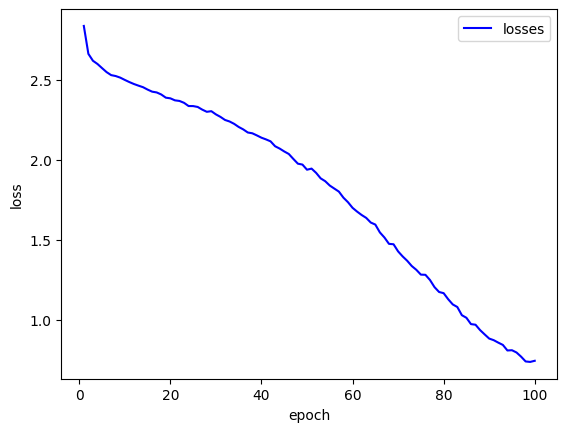

In [24]:
plot_losses(rnn_sh_losses)

### LSTM

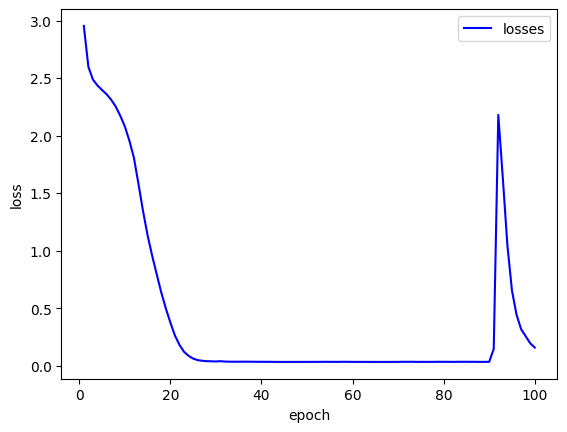

In [25]:
plot_losses(lstm_sh_losses)

## Report

According to the texts generated from different models and the losses during the training process of the models, analyze what is the reason for the difference in the result of models.

Which model works better and what do you think are the reasons?

<font color='#73FF73'><b>Your answer : </b></font>


LSTM result text is better than RNN. because the structure of the output is more alike to the Shakespeare plays. one of the potential reasons of the better performance of LSTM is the computational flexibility which is more in the LSTM and it can manage its memory cells more efficiently.

---
---

#2. FineTuning

FineTuning is a technique used in neural network training where a pre-trained model is further trained on a new task or dataset. It allows us to leverage the knowledge and representations learned by a pre-trained model and adapt it to a specific task or domain.

In this exercise, we first train the models with a `wikipedia` dataset that contains english texts, then we fine-tune this pre-trained model again with the Shakespeare play dataset to check the effect of this method on different models.

## Load Wikipedia dataset

In [26]:
!wget https://s3.amazonaws.com/fast-ai-nlp/wikitext-2.tgz

--2023-12-06 21:12:59--  https://s3.amazonaws.com/fast-ai-nlp/wikitext-2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.29.254, 52.216.114.205, 16.182.42.16, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.29.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4070055 (3.9M) [application/x-tar]
Saving to: ‘wikitext-2.tgz’

wikitext-2.tgz      100%[===================>]   3.88M  19.1MB/s    in 0.2s    

2023-12-06 21:13:00 (19.1 MB/s) - ‘wikitext-2.tgz’ saved [4070055/4070055]



In [27]:
!tar -xvzf '/content/wikitext-2.tgz' -C '/content/data'

wikitext-2/
wikitext-2/train.csv
wikitext-2/test.csv


In [28]:
!cat './data/wikitext-2/train.csv' | tr -d '\n' > ./data/wikitext.txt

##Preprocessing

In [29]:
def clean_wiki_data(data):
    repl=''
    data=re.sub('\(', repl, data)
    data=re.sub('\)', repl, data)
    for pattern in set(re.findall("=.*=",data)):
        data=re.sub(pattern, repl, data)
    for pattern in set(re.findall("<unk>",data)):
        data=re.sub(pattern,repl,data)
    for pattern in set(re.findall(r"[^\w ]", data)):
        repl=''
        if pattern=='-':
            repl=' '
        if pattern!='.' and pattern!="\'":
            data=re.sub("\\"+pattern, repl, data)

    return data

def load_data(filepath):
    f=open(filepath)
    return f.read()

In [30]:
wikidata=load_data("./data/wikitext.txt")
data=wikidata[:]
data=clean_wiki_data(data)
wikiPreprocessed_file = open("./data/wiki_preprocesed.txt", "w")
f = wikiPreprocessed_file.write(data)
wikiPreprocessed_file.close()

- Load data in amount of 50kb for finetuning

In [31]:
wi_data_file = "./data/wiki_preprocesed.txt"
wi_data = open(wi_data_file, 'r').read(50000)

In [32]:
wi_data = remove_extraneous_characters(wi_data.lower(), chars)
wi_data_size = len(wi_data)

wi_data = list(wi_data)
for i, ch in enumerate(wi_data):
    wi_data[i] = char_to_ix[ch]

wi_data = torch.tensor(wi_data).to(device)
wi_data = torch.unsqueeze(wi_data, dim=1)

## Pre-training by wikipedia dataset

### RNN

In [33]:
rnn_wi_losses = train_rnn(wi_data, wi_data_size, './model_wi_rnn.pth')

RNN(
  (dropout): Dropout(p=0.5, inplace=False)
  (encoder): Embedding(30, 30)
  (rnn): RNN(30, 512, num_layers=6, batch_first=True)
  (decoder): Linear(in_features=512, out_features=30, bias=True)
)
epoch=0
current model with loss=2.7290302651827454 saved at ./model_wi_rnn.pth
epoch=1
current model with loss=2.6248034629665438 saved at ./model_wi_rnn.pth
epoch=2
current model with loss=2.5716143826969335 saved at ./model_wi_rnn.pth
epoch=3
current model with loss=2.5590264074137954 saved at ./model_wi_rnn.pth
epoch=4
current model with loss=2.545735462767179 saved at ./model_wi_rnn.pth
epoch=5
current model with loss=2.5204814047109885 saved at ./model_wi_rnn.pth
epoch=6
current model with loss=2.512947760644506 saved at ./model_wi_rnn.pth
epoch=7
current model with loss=2.4945776931575088 saved at ./model_wi_rnn.pth
epoch=8
current model with loss=2.4864187905045805 saved at ./model_wi_rnn.pth
epoch=9
Loss [epoch=9] = 2.480671847452883
Train Sample +++++++++++++++++++++++++++++++++++

### LSTM

In [34]:
lstm_wi_losses = train_lstm(wi_data, wi_data_size, './model_wi_lstm.pth')

epoch=0
current model with loss=2.765177064254636 saved at ./model_wi_lstm.pth
epoch=1
current model with loss=2.4869486464828743 saved at ./model_wi_lstm.pth
epoch=2
current model with loss=2.4286629821433396 saved at ./model_wi_lstm.pth
epoch=3
current model with loss=2.3936734375406483 saved at ./model_wi_lstm.pth
epoch=4
current model with loss=2.370305915347865 saved at ./model_wi_lstm.pth
epoch=5
current model with loss=2.3500055856392033 saved at ./model_wi_lstm.pth
epoch=6
current model with loss=2.324465608987652 saved at ./model_wi_lstm.pth
epoch=7
current model with loss=2.2888159341499454 saved at ./model_wi_lstm.pth
epoch=8
current model with loss=2.2492011433742087 saved at ./model_wi_lstm.pth
epoch=9
Loss [epoch=9] = 2.1894182748481876
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
d . ck precanoprind d founa ltie od twh finexoonbs meve eefthedatralan is   wakioes  bar fangathe  fcantrenolle groth thenddisond ondeconghome wed . urecu reshofieison th wro fragi

## Finetuning by Shakespeare

- Define the following functions to use the previous model as a pre-trained model and fine-tunes it using Shakespeare's plays dataset with lower learning rate.

In [35]:
def finetune_rnn(data, data_size, model_save_file, model_pretrained_path):
    # RNN parameters
    hidden_size = 512
    num_layers = 6
    lr = 0.001
    epoch_num = 100
    losses = []

    ####################################
    ######### Your code begins #########
    ####################################
    # In this section finetune the model that trained by wikipedia dataset with Shakespeare plays dataset
    model = RNN(input_size=vocab_size, output_size=vocab_size, hidden_size=hidden_size, num_layers=num_layers, dropout_enable=False)
    model = model.to(device)

    # Load the pre-trained weights
    model.load_model(model_pretrained_path)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epoch_num):
        loss = train_epoch(model, data, data_size, epoch, optimizer)
        losses.append(loss)

    # Save the fine-tuned model
    model.save_model(model_save_file)
    ####################################
    ######### Your code ends ###########
    ####################################

    return losses

In [36]:
def finetune_lstm(data, data_size, model_save_file, model_pretrained_path):
    # LSTM parameters
    hidden_size = 512
    num_layers = 3
    lr = 0.001
    epoch_num = 100
    losses = []

    ####################################
    ######### Your code begins #########
    ####################################
    # In this section finetune the model that trained by wikipedia dataset with Shakespeare plays dataset
    # Create LSTM model
    model = LSTM(input_size=vocab_size, output_size=vocab_size, hidden_size=hidden_size, num_layers=num_layers, dropout_enable=False)
    model = model.to(device)

    # Load the pre-trained weights
    model.load_model(model_pretrained_path)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epoch_num):
        loss = train_epoch(model, data, data_size, epoch, optimizer)
        losses.append(loss)

    # Save the fine-tuned model
    model.save_model(model_save_file)
    ####################################
    ######### Your code ends ###########
    ####################################

    return losses

### RNN

In [37]:
rnn_sh_finetune_losses = finetune_rnn(sh_data, sh_data_size, './model_sh_finetune_rnn.pth', './model_wi_rnn.pth')

Loss [epoch=9] = 2.1707068847285376
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
e chigocopeu avoworo thowe e iss mmid d se th urs y otnupageeere bemcien wawiun athaudeanonomed
 coverenessth fof te ped ce rt le amee asenir ad. she berchillout irnthesthatithe anor mse broranthearhen
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loss [epoch=19] = 1.804780489868588
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
noreiuthe d mmen wina d
m
br
s ans f amaniotinirme: coe d inrct s by gh f 
tis
fachareyess ak ppe rand
prons nd cia me iuranik 
ld tomalld o ethobyothens whalyende e
ad my gomeco chthee hind ar s
ionin
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loss [epoch=29] = 1.5068895932700899
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
llidethatiul te gimale at athationof
pry te thernse g
imathal oeano me pf ck se t le a: ces b:
red
pe nedgouel lg ct y thay t towerne amatoug cacene mad bbrert ga bemoo codonousuthetheref
llir

### LSTM

In [38]:
lstm_sh_finetune_losses = finetune_lstm(sh_data, sh_data_size, './model_sh_finetune_lstm.pth', './model_wi_lstm.pth')

Loss [epoch=9] = 1.0464529560671911
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
sul
miuve acabbuma murumato ouls

we hil whilllllllavisoullr. f brr siuse erisonds thicethicarin h go uniun
 malth: sus:

us i he figiuifren athe lele the veve m the tor m yor yofi wholed m buryey keth
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loss [epoch=19] = 0.28446573784781826
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
iol bollfi h.
ld witi o iere the me ucoos owern m
:
.
:
dindear waf aue
n lfomst f mommatoronenoselased lden we te te:
elod wif arit.
ar th latheson
f ao p.
fie
swhno hen athey winviff y wn d
swhe meva
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loss [epoch=29] = 0.12201122670537895
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
t petothinenl m iume cie m n be d
y tinghinvimer be s oomy d re oto y bliethouse.
nconis yo omomas: abr fiad shen athe otive fo whir mns t th t th ed bthir m
athes t wauranis outit de fir p

## Plotting Losses

In [39]:
def plot_losses_together(losses1, losses2):
    xpoints = np.array(range(len(losses1)))
    ypoints1 = np.array(losses1)
    ypoints2 = np.array(losses2)

    plt.plot(xpoints, ypoints1, color='blue',label='base_losses' )
    plt.plot(xpoints, ypoints2, color='red',label='finetune_losses' )
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

### RNN

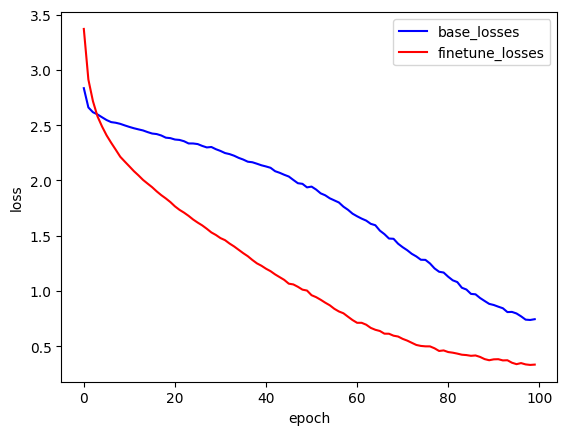

In [42]:
plot_losses_together(rnn_sh_losses[1:], rnn_sh_finetune_losses)

### LSTM

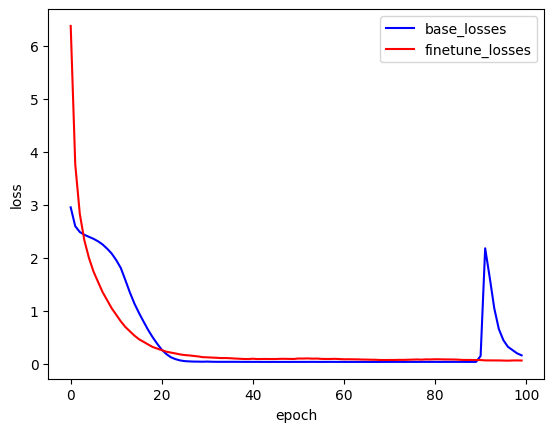

In [43]:
plot_losses_together(lstm_sh_losses[1:], lstm_sh_finetune_losses)

## Report

As you can see, fine-tuning has an effect in improving the training of the main model.

By analyzing the obtained results, state the advantage of finetuning after pre-training the model by public dataset, and compare its performance in different models

<font color='#73FF73'><b>Your answer : </b></font>

----
----

#3. Experiment on different datasets

In the previous section, you saw the performance results of the text generation model using the Shakespeare plays dataset. In the following, you will check the results of the LSTM model on the dialogues of the `Friends series`

## Load dataset

In [44]:
!wget https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-09-08/friends.csv -O ./data/Friends.csv

--2023-12-06 21:26:34--  https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-09-08/friends.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5383844 (5.1M) [text/plain]
Saving to: ‘./data/Friends.csv’

./data/Friends.csv  100%[===================>]   5.13M  --.-KB/s    in 0.08s   

2023-12-06 21:26:35 (66.2 MB/s) - ‘./data/Friends.csv’ saved [5383844/5383844]



## preprocessing

In [45]:
friends = pd.read_csv('./data/Friends.csv')
friends = friends.dropna()
friends = friends[friends['speaker'].str.contains('SCENE')==False]
friends['speaker'] = friends['speaker'].apply(lambda sp: sp.lower().capitalize().split(' ')[0])
friends_texts = friends.drop(['episode','season','scene','utterance'], axis='columns')
friends_texts.head()

,text,speaker
0,There's nothing to tell! He's just some guy I ...,Monica
1,"C'mon, you're going out with the guy! There's ...",Joey
2,"All right Joey, be nice. So does he have a hum...",Chandler
3,"Wait, does he eat chalk?",Phoebe
4,"(They all stare, bemused.)",Scene


In [46]:
f = open("./data/fiends.txt", "w")
for i,row in friends_texts.iterrows():
    f.write(row['speaker'] + ':\n' + row['text'] + '\n\n')

f.close()

In [47]:
fr_data_file = "./data/fiends.txt"
fr_data = open(fr_data_file, 'r').read(30000)
fr_data = remove_extraneous_characters(fr_data.lower(), chars)
fr_data_size = len(fr_data)

fr_data = list(fr_data)
for i, ch in enumerate(fr_data):
    fr_data[i] = char_to_ix[ch]

fr_data = torch.tensor(fr_data).to(device)
fr_data = torch.unsqueeze(fr_data, dim=1)

## Train finetuned LSTM by friends dataset

In [48]:
lstm_fr_finetune_losses = finetune_lstm(fr_data, fr_data_size, './model_fr_lstm.pth', './model_wi_lstm.pth')

Loss [epoch=9] = 1.0821877558466415
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
eves aveveok. f at wet lofinothed abutabo. t a:ist...
:
wng..
nicef as th whe gotohisd:

 gut be toer jurexcaves atss:

fowighooup tork anet the yofedet blecho tong an
r ah yor kate.. ano ay.. l: ane b
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loss [epoch=19] = 0.27898472201236535
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
wes l me a:
t 
y.


. t f oeoher ng pathe s cerni w 
nd t theas:



iomo who g cot be ly t s to we wo anose l:

:

y hap ss:
curand
mowangtan marhe pot t.

uringungar
gros: t blore wau nn
il:

howherou
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loss [epoch=29] = 0.12478361766732915
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
kak th r lo le s jum ichedyondl owa:
rere d ifer w pr lou a:
t w blvanot lonod t aloeore callou thas anth siss js wes me avebe s ht moy t s to incthesnour
 onoutidayoor: i theay cadono boon

## Generating texts

In [49]:
best_model_lstm =  LSTM(vocab_size, vocab_size, 512, 3).to(device)
best_model_lstm.load_model('./model_fr_lstm.pth')
print("best loss", min(lstm_fr_finetune_losses))
generate_text(best_model_lstm, fr_data, fr_data_size)

best loss 0.062849813455742
Eaxmple of generated text --------------------------------------------------------------------------
alabooeeto ronig yom y

im f werays:


s pa h.

t peutha:
an m:

s ke. me au d al a:






purom th kyoh acar osthrineisow hat w t at t ppeve ghereei dl tu t ppenout bigngout theruut ynd t poongracen wh
wherl:


ny i sso jut g w p is han mmernghor che me... thean yo bave ive.. ghs pr kal y t r kn
stheronisowat t at r g moalel:
ou ai a:


jundoel and


d

oe imu wheshresi icaweng n outind
au t rnonind.
ure indd t pube ha tam li le a:



jup t.
y t hetichend t au whel:

m momas:



rerki


ig y pp bllechednowassst y isf inan yousouticheas jug kngucar yo butonorerery atondneng cheto jupeverthre gof keyed:
sce preli gea:
wesesey
wat.

ou 


yos m neeamous o h i o jusss a anoutom thi aralllllllllloolegsther yo yo bu ten sss aro.

ppech cheriseyoda ki wholit ct le.. cani s i arendabascald cheres





g momorg pper y cheng we y wn osthrevedeeet t f mandoutok..

no s

- As you can see, the LSTM network has been able to learn the features of different datasets in terms of sentence length and writing style and use it in text generation.

## The output of finetuned models on different datasets on the input sample

- In this section, you can see the result of the text generated by models with a sample input text.

In [50]:
input_sample_text = "Hello, have a nice day.\n"

In [58]:
best_model_lstm =  LSTM(vocab_size, vocab_size, 512, 3).to(device)
best_model_lstm.load_model('./model_fr_lstm.pth')
generate_text(best_model_lstm, fr_data, fr_data_size, create_input_sample_dataset(input_sample_text),100)

Eaxmple of generated text --------------------------------------------------------------------------

cks ithere.
 ut lel:

y y pris:

moplpe ney

youroul:

mp ghe ly cheameroumeabusonowasss js tes:




----------------------------------------------------------------------------------------------------


In [59]:
best_model_lstm =  LSTM(vocab_size, vocab_size, 512, 3).to(device)
best_model_lstm.load_model('./model_sh_finetune_lstm.pth')
generate_text(best_model_lstm, sh_data, sh_data_size, create_input_sample_dataset(input_sample_text),100)

Eaxmple of generated text --------------------------------------------------------------------------

meankelelloouthear n n tomor hinof y
n
are outilo andi t llinththrali oor hine thashen athe urvie si
----------------------------------------------------------------------------------------------------


## Report

According to the sample input and output produced by the fine-tuned model with the Shakespeare dataset and the Friends dataset, which output is more meaningful and what is the reason for this difference?

<font color='#73FF73'><b>Your answer : </b></font>

----
----